## Tasks Included

*  Coding a GPT-like large language model (LLM) that can be trained to
   generate human-like text
*  Normalizing layer activations to stabilize neural network training

*  Adding shortcut connections in deep neural networks to train models
   more effectively

*  Implementing transformer blocks to create GPT models of various sizes
   Computing the number of parameters and storage requirements of GPT
   models

##4.1 Coding an LLM architecture

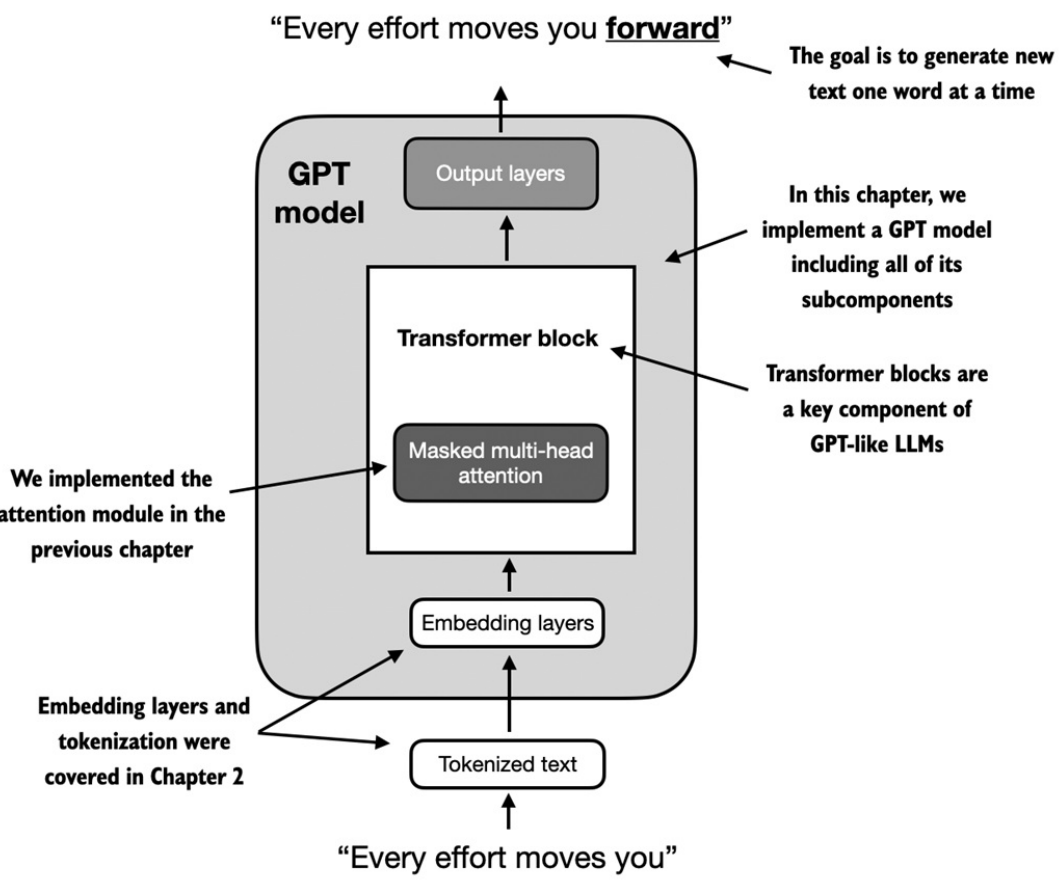

**A mental model of a GPT model. Next to the embedding layers, it consists of one or
more transformer blocks containing the masked multi-head attention module we implemented in
the previous chapter.**

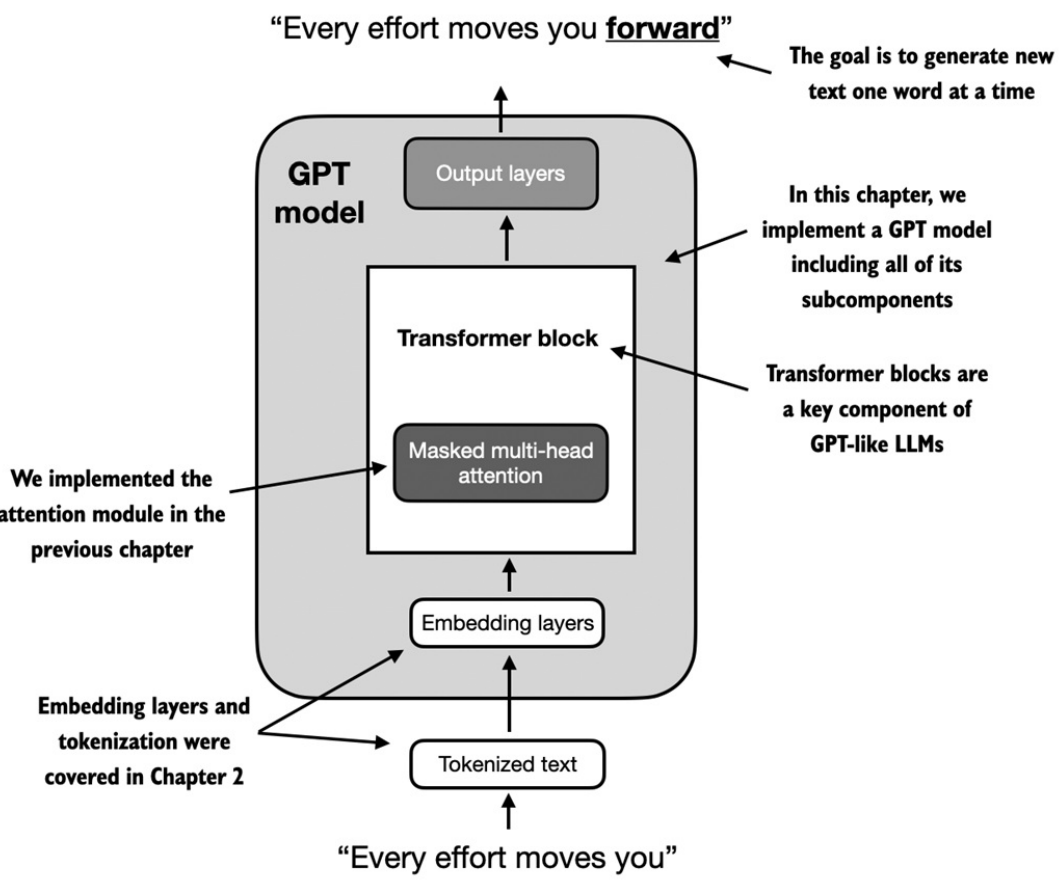

**A mental model outlining the order in which we code the GPT architecture. In this
chapter, we will start with the GPT backbone, a placeholder architecture, before we get to the
individual core pieces and eventually assemble them in a transformer block for the final GPT
architecture.**

In [6]:
from importlib.metadata import version

import matplotlib
import tiktoken
import torch

print("matplotlib version:", version("matplotlib"))
print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

matplotlib version: 3.8.0
torch version: 2.5.0+cu121
tiktoken version: 0.8.0


Configuration details for the 124 million parameter GPT-2 model include:

In [7]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [8]:
import torch
import torch.nn as nn


class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This layer does nothing and just returns its input.
        return x

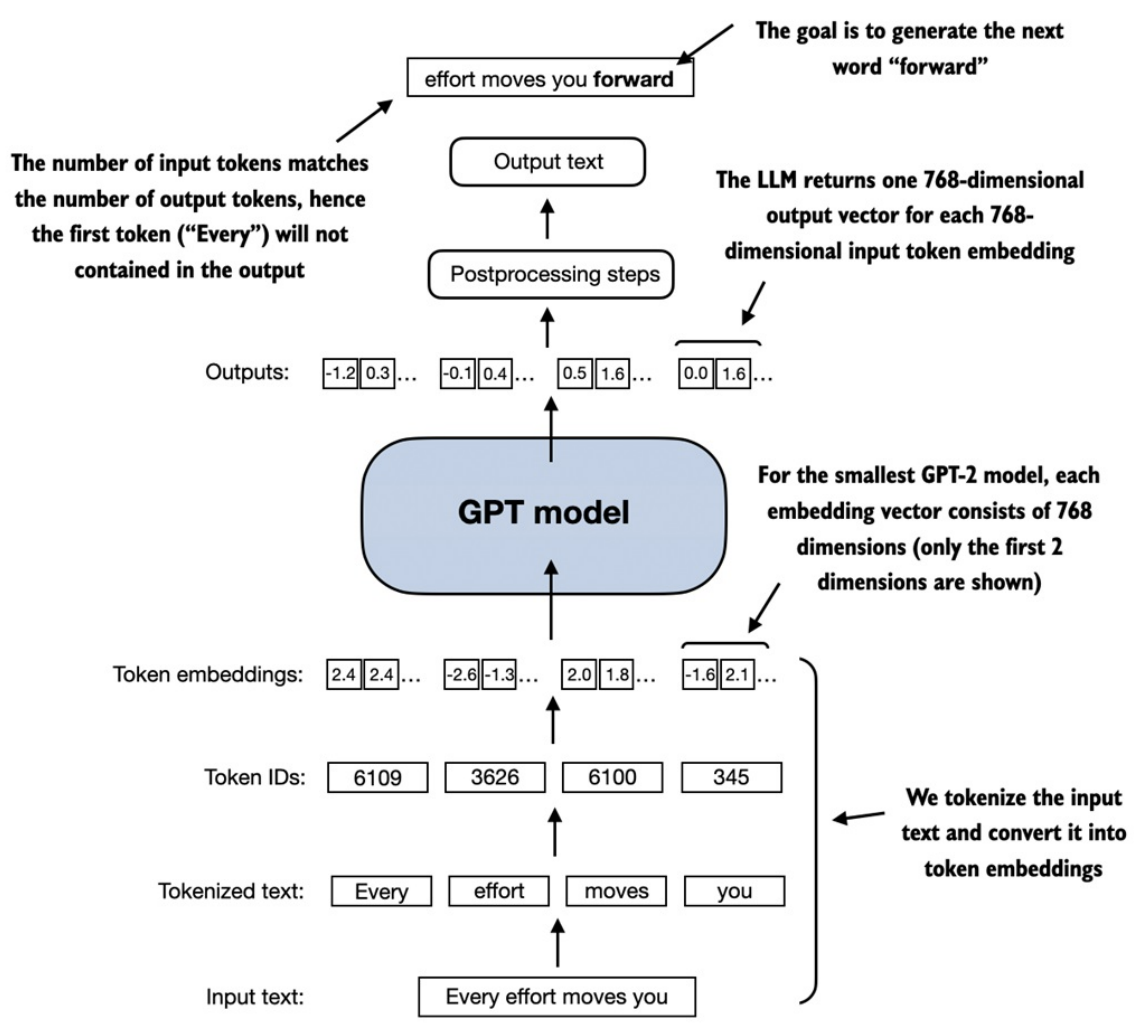

**A big-picture overview showing how the input data is tokenized, embedded, and fed to
the GPT model. Note that in our DummyGPTClass coded earlier, the token embedding is handled
inside the GPT model. In LLMs, the embedded input token dimension typically matches the
output dimension.**

To implement the steps, we tokenize a batch consisting of two text inputs for the GPT model using the tiktoken tokenizer introduced in previous chapter

In [9]:
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


Next, we initialize a new 124 million parameter DummyGPTModel instance and
feed it the tokenized batch:

In [10]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


The output tensor has two rows corresponding to the two text samples. Each
text sample consists of 4 tokens; each token is a 50,257-dimensional vector,
which matches the size of the tokenizer's vocabulary.

##4.2 Normalizing activations with layer normalization

Training deep neural networks with many layers can sometimes prove
challenging due to issues like vanishing or exploding gradients. These issues
lead to unstable training dynamics and make it difficult for the network to
effectively adjust its weights, which means the learning process struggles to
find a set of parameters (weights) for the neural network that minimizes the
loss function. In other words, the network has difficulty learning the
underlying patterns in the data to a degree that would allow it to make
accurate predictions or decisions

------------------------------------------------------------------------------------------
In this section, we will implement layer normalization to improve the
stability and efficiency of neural network training.

--------------------------------------------------------------------------------------------
The main idea behind layer normalization is to adjust the activations
(outputs) of a neural network layer to have a mean of 0 and a variance of 1,
also known as unit variance. This adjustment speeds up the convergence to
effective weights and ensures consistent, reliable training. As we have seen in
the previous section, based on the DummyLayerNorm placeholder, in GPT-2
and modern transformer architectures, layer normalization is typically applied
before and after the multi-head attention module and before the final output
layer

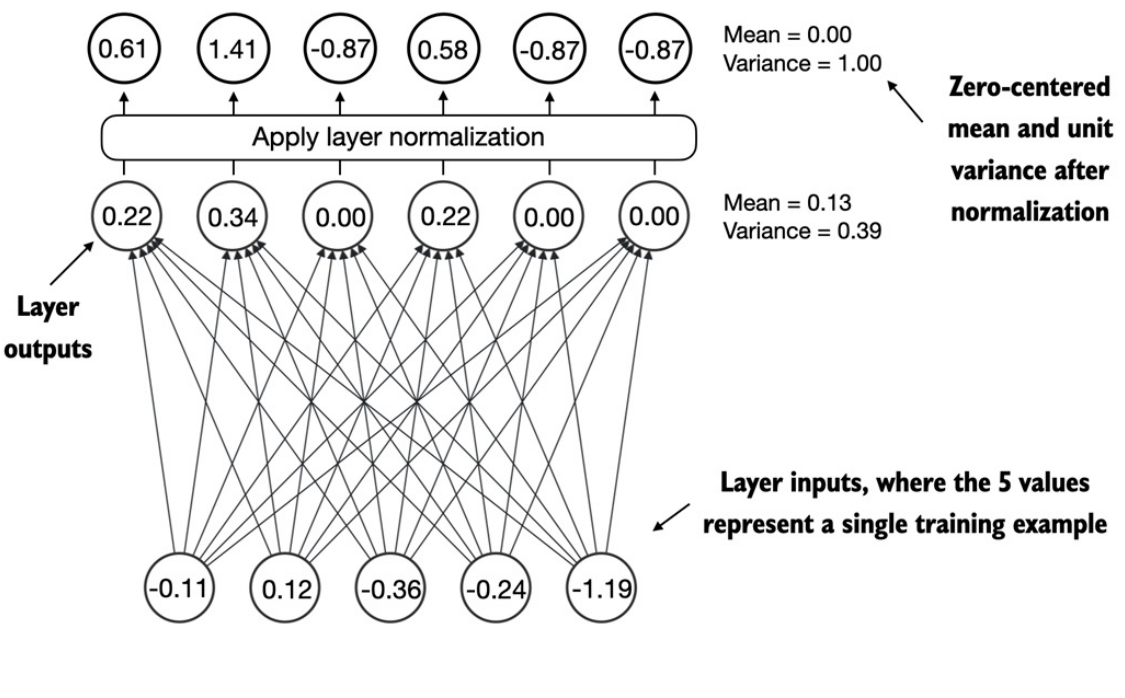

**An illustration of layer normalization where the 5 layer outputs, also called
activations, are normalized such that they have a zero mean and variance of 1.**

We can recreate the example shown in Figure via the following code,
where we implement a neural network layer with 5 inputs and 6 outputs that
we apply to two input examples:

In [11]:
torch.manual_seed(123)
batch_example = torch.randn(2, 5) #A
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


Before we apply layer normalization to these outputs, let's examine the mean and variance:

In [12]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


The first row in the mean tensor above contains the mean value for the first
input row, and the second output row contains the mean for the second input
row.

Using `keepdim=True` in operations like mean or variance calculation ensures
that the output tensor retains the same shape as the input tensor, even though
the operation reduces the tensor along the dimension specified via dim. For
instance, without `keepdim=True`, the returned mean tensor would be a 2-
dimensional vector [0.1324, 0.2170] instead of a 2×1-dimensional matrix
`[[0.1324], [0.2170]]`.

The `dim` parameter specifies the dimension along which the calculation of the
statistic (here, mean or variance) should be performed in a tensor, as shown
in Figure 4.6.

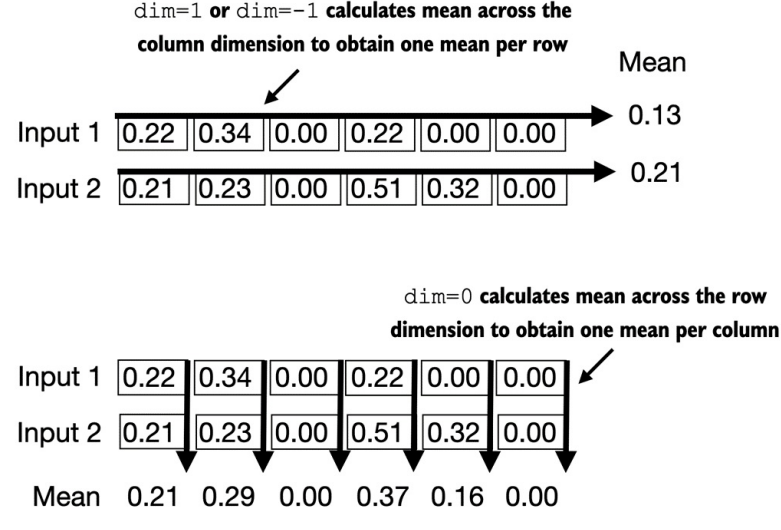

**An illustration of the dim parameter when calculating the mean of a tensor. For
instance, if we have a 2D tensor (matrix) with dimensions [rows, columns], using dim=0 will
perform the operation across rows (vertically, as shown at the bottom), resulting in an output
that aggregates the data for each column. Using dim=1 or dim=-1 will perform the operation
across columns (horizontally, as shown at the top), resulting in an output aggregating the data for
each row.**

*As Figure above explains, for a 2D tensor (like a matrix), using dim=-1 for
operations such as mean or variance calculation is the same as using dim=1.
This is because -1 refers to the tensor's last dimension, which corresponds to
the columns in a 2D tensor. Later, when adding layer normalization to the
GPT model, which produces 3D tensors with shape [batch_size,
num_tokens, embedding_size], we can still use dim=-1 for normalization
across the last dimension, avoiding a change from dim=1 to dim=2.*

Next, let us apply layer normalization to the layer outputs we obtained earlier.
The operation consists of subtracting the mean and dividing by the square
root of the variance (also known as standard deviation):

In [13]:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Normalized layer outputs:\n", out_norm)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


**A Layer normalization class**

In [14]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

**Scale and shift**

*  Note that in addition to performing the normalization by subtracting the
   mean and dividing by the variance, we added two trainable parameters, a scale and a shift parameter

*  The initial scale (multiplying by 1) and shift (adding 0) values don't have
   any effect; however, scale and shift are trainable parameters that the LLM automatically adjusts during training if it is determined that doing so would improve the model's performance on its training task

*  This allows the model to learn appropriate scaling and shifting that best
   suit the data it is processing

*  Note that we also add a smaller value (eps) before computing the square root
   of the variance; this is to avoid division-by-zero errors if the variance is 0
   
**Biased variance**

*  In the variance calculation above, setting unbiased=False means using the formula $\sigma^2 = \frac{1}{N} \sum_{i=1}^{N} (x_i - \mu)^2$ to compute the variance where n is the sample size (here, the number of features or columns); this formula does not include Bessel's correction (which uses n-1 in the denominator), thus providing a biased estimate of the variance

*  For LLMs, where the embedding dimension n is very large, the difference
   between using n and n-1 is negligible

*  However, GPT-2 was trained with a biased variance in the normalization   layers, which is why we also adopted this setting for compatibility reasons with the pretrained weights that we will load in later chapters

Let's now try out LayerNorm in practice:

In [15]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)


In [16]:
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[-2.9802e-08],
        [ 0.0000e+00]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


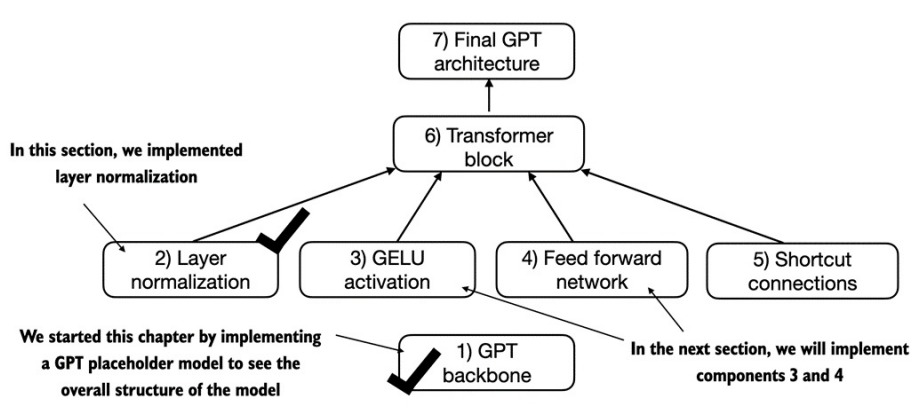

**A mental model listing the different building blocks we implement in this chapter to
assemble the GPT architecture.**

**Layer normalization vs batch normalization**

If you are familiar with batch normalization, a common and traditional
normalization method for neural networks, you may wonder how it compares
to layer normalization. Unlike batch normalization, which normalizes across
the batch dimension, layer normalization normalizes across the feature
dimension. LLMs often require significant computational resources, and the
available hardware or the specific use case can dictate the batch size during
training or inference. Since layer normalization normalizes each input
independently of the batch size, it offers more flexibility and stability in these
scenarios. This is particularly beneficial for distributed training or when
deploying models in environments where resources are constrained.

##4.3 Implementing a feed forward network with GELU activations

*  In this section, we implement a small neural network submodule that is used
   as part of the transformer block in LLMs
*  We start with the activation function
*  In deep learning, ReLU (Rectified Linear Unit) activation functions are
   commonly used due to their simplicity and effectiveness in various neural network architectures
*  In LLMs, various other types of activation functions are used beyond the
   traditional ReLU; two notable examples are GELU (Gaussian Error Linear Unit) and SwiGLU (Swish-Gated Linear Unit)
*  GELU and SwiGLU are more complex, smooth activation functions incorporating  Gaussian and sigmoid-gated linear units, respectively, offering better performance for deep learning models, unlike the simpler, piecewise linear function of ReLU

*  GELU (Hendrycks and Gimpel 2016) can be implemented in several ways; the exact version is defined as GELU(x)=x⋅Φ(x), where Φ(x) is the cumulative distribution function of the standard Gaussian distribution.

*  In practice, it's common to implement a computationally cheaper approximation:
$$
\text{GELU}(x) \approx 0.5 \cdot x \cdot \left( 1 + \tanh \left[ \sqrt{\frac{2}{\pi}} \cdot \left( x + 0.044715 \cdot x^3 \right) \right] \right)
$$

 (the original GPT-2 model was also trained with this approximation)

In [17]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

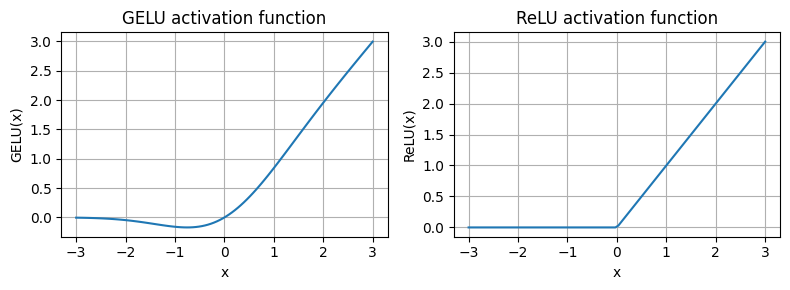

In [18]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

* As we can see, ReLU is a piecewise linear function that outputs the input directly if it is positive; otherwise, it outputs zero

* GELU is a smooth, non-linear function that approximates ReLU but with a non-zero gradient for negative values (except at approximately -0.75)

* Next, let's implement the small neural network module, `FeedForward`, that we will be using in the LLM's transformer block later:

In [19]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [20]:
print(GPT_CONFIG_124M["emb_dim"])

768


As we can see in the preceding code, the FeedForward module is a small
neural network consisting of two Linear layers and a GELU activation
function. In the 124 million parameter GPT model, it receives the input
batches with tokens that have an embedding size of 768 each via the
GPT_CONFIG_124M dictionary where `GPT_CONFIG_124M["emb_dim"] = 768`.

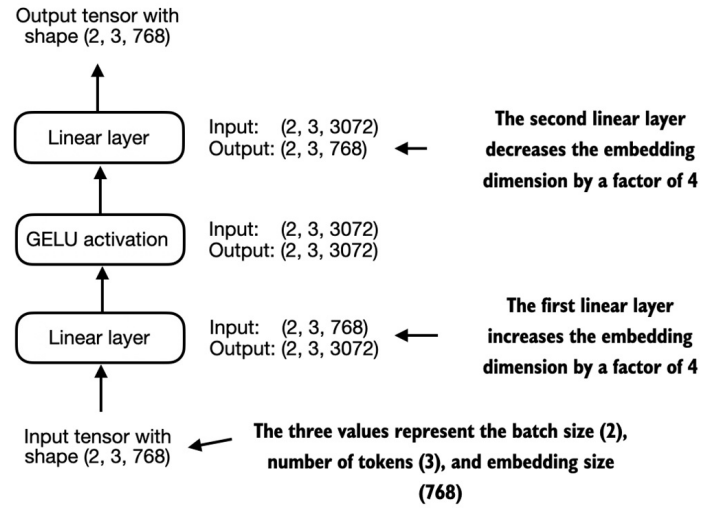

**Figure provides a visual overview of the connections between the layers of the feed forward
neural network. It is important to note that this neural network can accommodate variable batch
sizes and numbers of tokens in the input. However, the embedding size for each token is
determined and fixed when initializing the weights.**

Let's initialise a new `FeedForward` module with a token embedding size of 768 and feed it a batch input with 2 samples and 3 tokens each:

In [21]:
ffn = FeedForward(GPT_CONFIG_124M)

# input shape: [batch_size, num_token, emb_size]
x = torch.rand(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


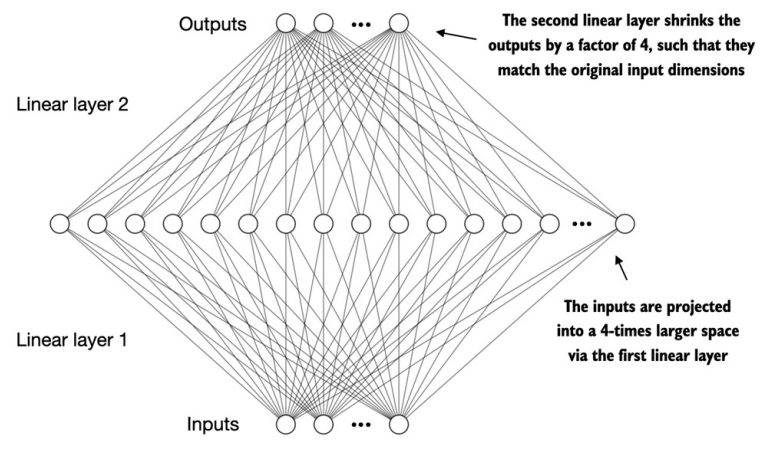

**An illustration of the expansion and contraction of the layer outputs in the feed
forward neural network. First, the inputs expand by a factor of 4 from 768 to 3072 values. Then,
the second layer compresses the 3072 values back into a 768-dimensional representation.**

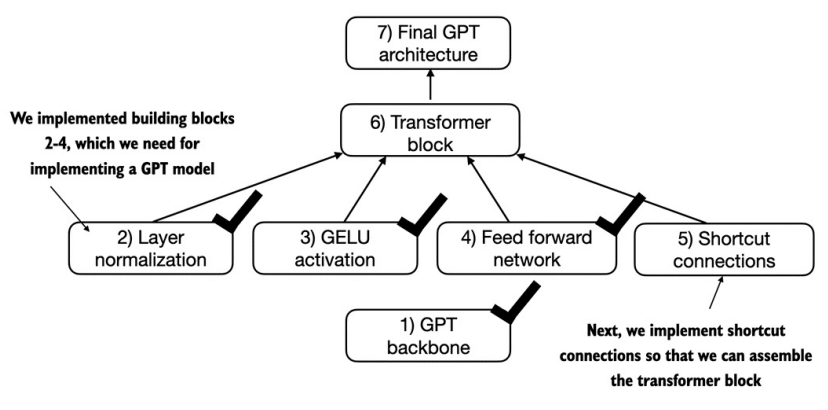

##4.4 Adding shortcut connections


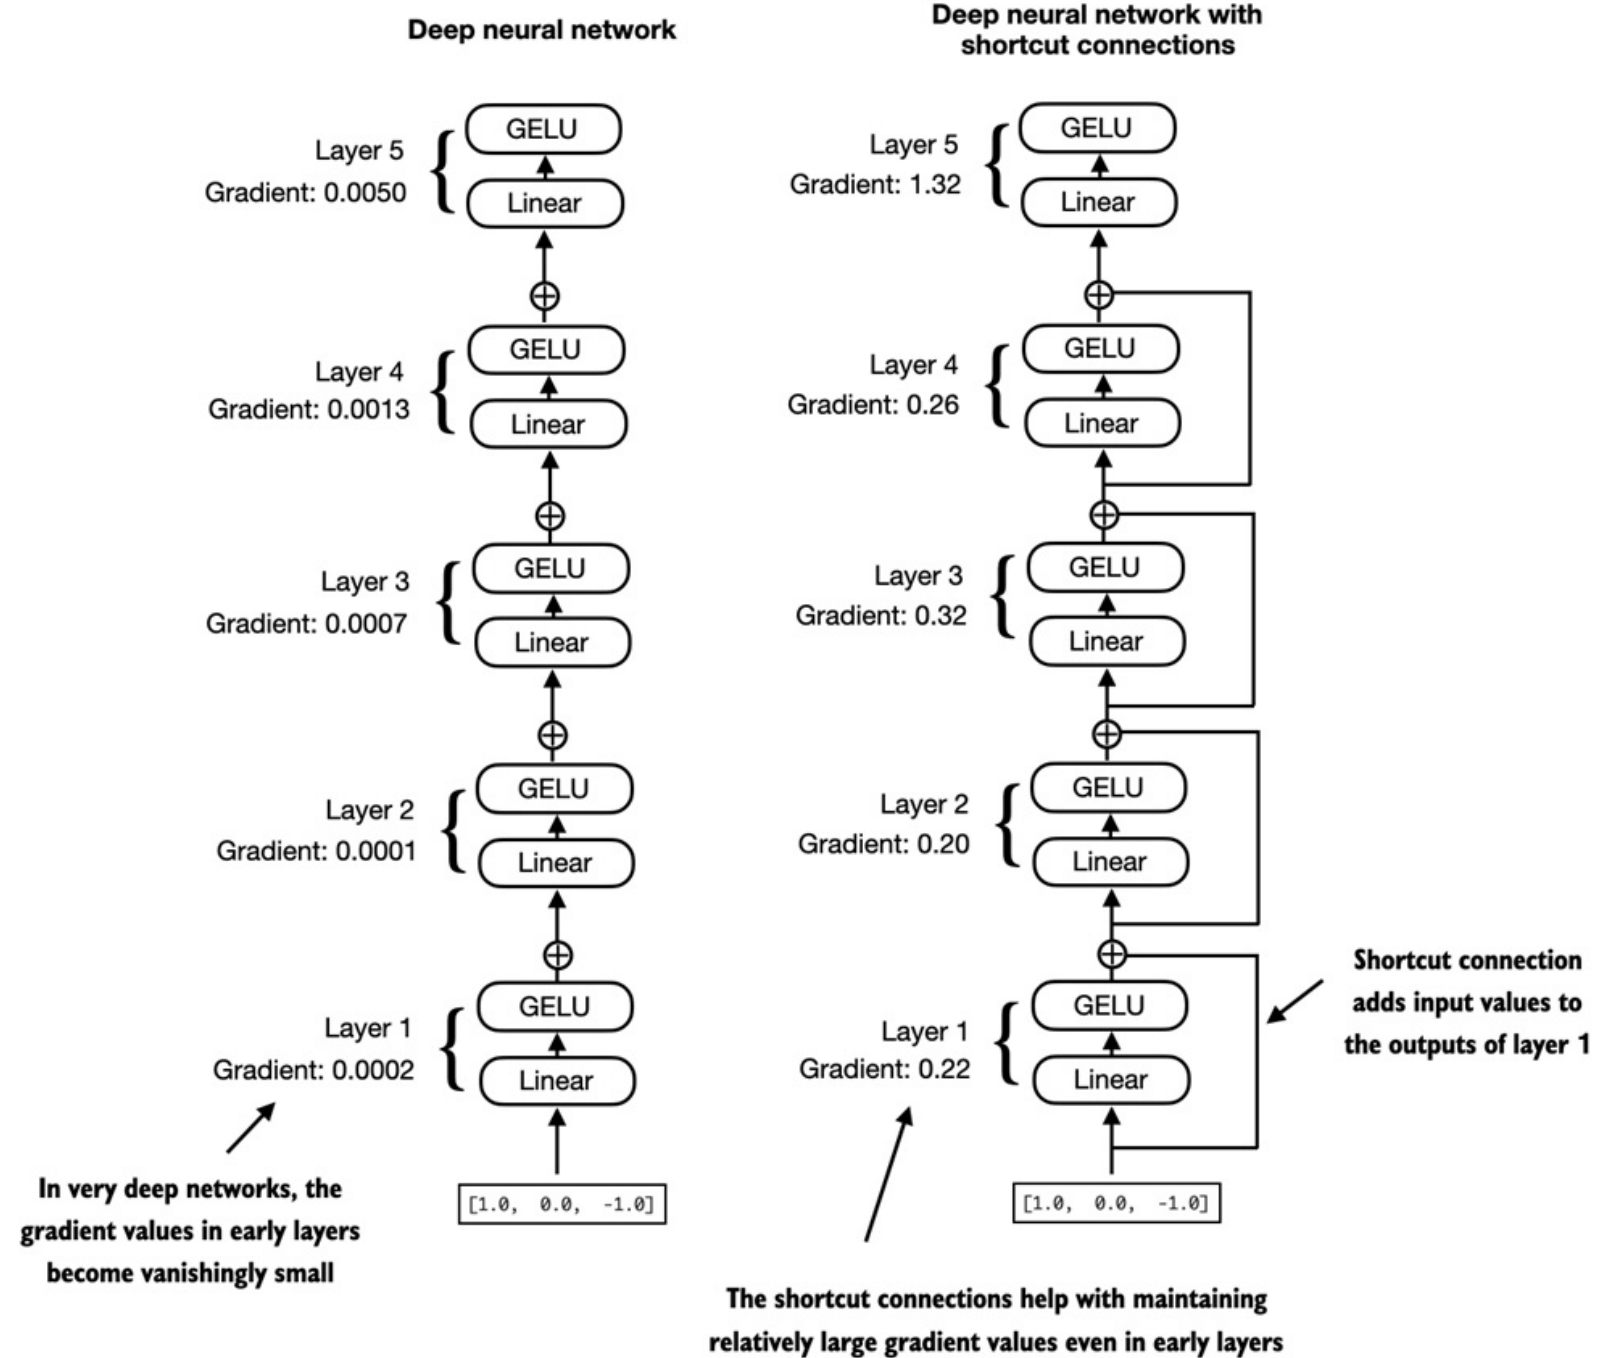

**A Neural Network to illustrate shortcut connections**

In [25]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output = layer(x)
            # Check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x




Let's write a funtion that can print gradients

In [26]:
def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calculate loss based on how close the target
    # and output are
    loss = nn.MSELoss()
    loss = loss(output, target)

    # Backward pass to calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

*  Let's print the gradient values first without shortcut connections:

In [23]:
layer_sizes = [3, 3, 3, 3, 3, 1]

sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173584925942123
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


*  Next, let's print the gradient values **with** shortcut connections:

In [24]:

torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694105327129364
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


*  As we can see based on the output above, shortcut connections prevent the gradients from vanishing in the early layers `(towards layer.0)`

*  We will use this concept of a shortcut connection next when we implement a transformer block

In the preceding code, we specify a loss function that computes how close the
model output and a user-specified target (here, for simplicity, the value 0)
are. Then, when calling `loss.backward()`, PyTorch computes the loss
gradient for each layer in the model. We can iterate through the weight
parameters via `model.named_parameters()`. Suppose we have a `3×3` weight
parameter matrix for a given layer. In that case, this layer will have `3×3`
gradient values, and we print the mean absolute gradient of these `3×3`
gradient values to obtain a single gradient value per layer to compare the
gradients between layers more easily

##4.5 Connecting attention and linear layers in a transformer block

*  In this section, we now combine the previous concepts into a so-called transformer block
*  A transformer block combines the causal multi-head attention module from the previous chapter with the linear layers, the feed forward neural network we implemented in an earlier section
*  In addition, the transformer block also uses dropout and shortcut connections

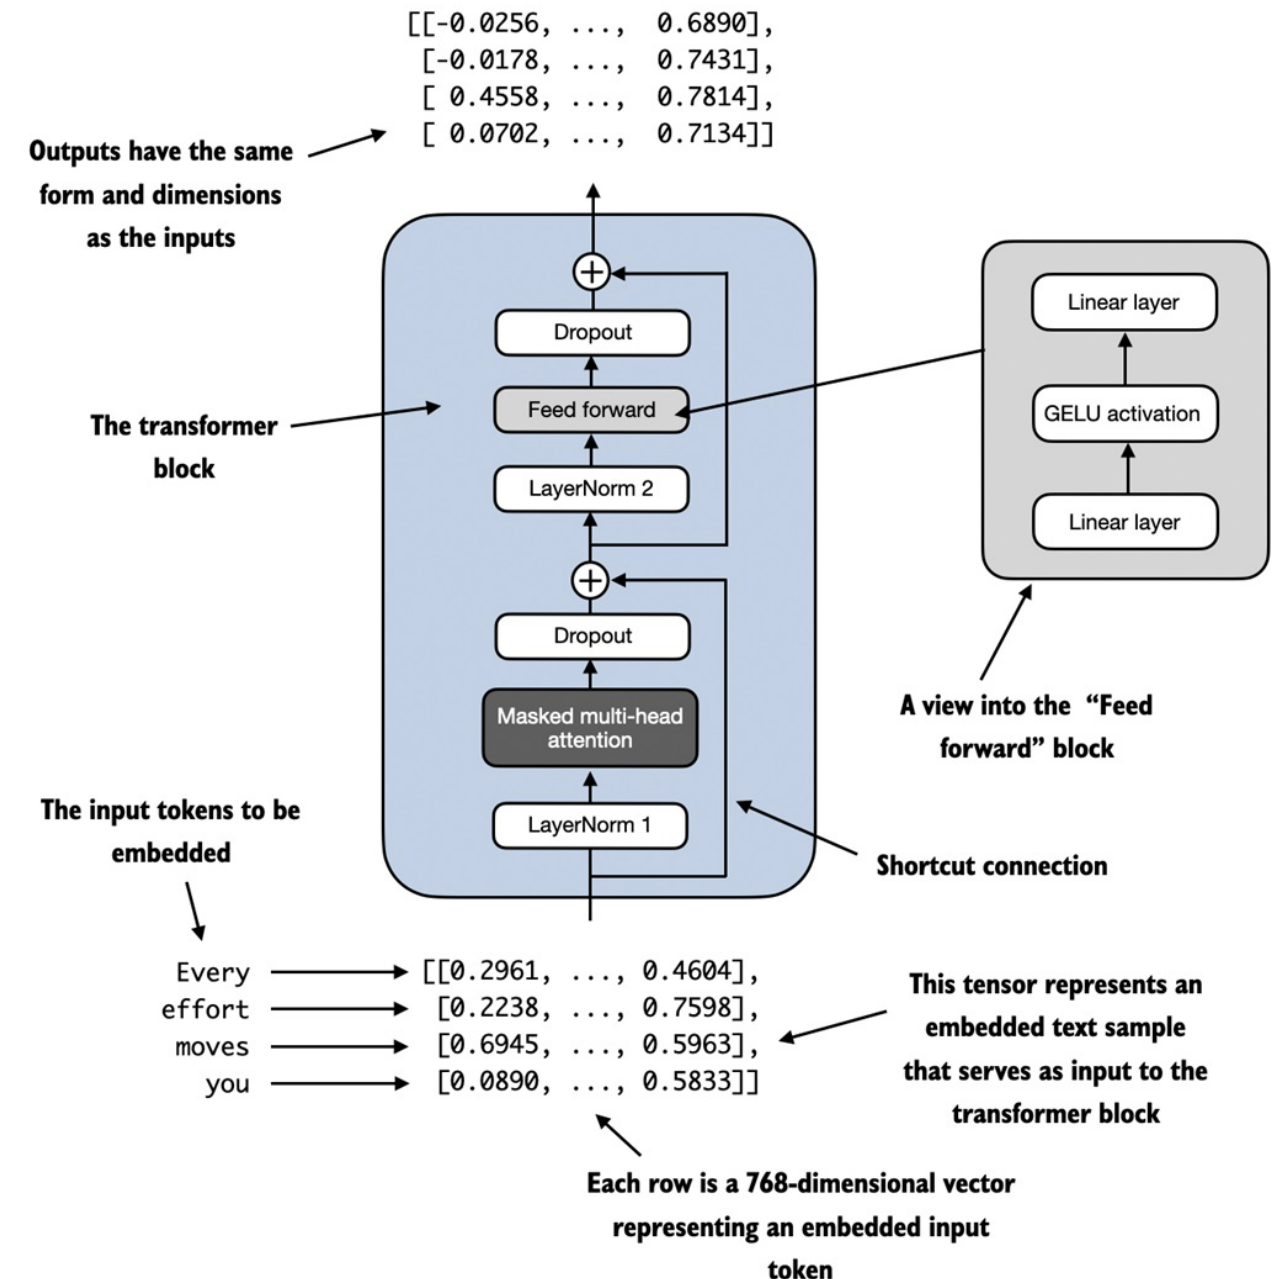

**Multihead Attention**

In [28]:
import tiktoken
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True, num_workers=0):
    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader


class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads  # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)  # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)  # optional projection

        return context_vec

**The transformer block component of GPT**

In [29]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x

**What makes this implementation special**

*  Layer normalization (LayerNorm) is applied before each of these two
components, and dropout is applied after them to regularize the model and
prevent overfitting. This is also known as Pre-LayerNorm. Older
architectures, such as the original transformer model, applied layer
normalization after the self-attention and feed-forward networks instead,
known as Post-LayerNorm, which often leads to worse training dynamics

*  The class also implements the forward pass, where each component is
followed by a shortcut connection that adds the input of the block to its
output. This critical feature helps gradients flow through the network during
training and improves the learning of deep models

Using the GPT_CONFIG_124M dictionary we defined earlier, let's instantiate a transformer block and feed it some sample data:

In [30]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


As we can see from the code output, the transformer block maintains the
input dimensions in its output, indicating that the transformer architecture
processes sequences of data without altering their shape throughout the
network.
The preservation of shape throughout the transformer block architecture is
not incidental but a crucial aspect of its design. This design enables its
effective application across a wide range of sequence-to-sequence tasks,
where each output vector directly corresponds to an input vector, maintaining
a one-to-one relationship. However, the output is a context vector that
encapsulates information from the entire input sequence, as we learned in previous notebook. This means that while the physical dimensions of the sequence
(length and feature size) remain unchanged as it passes through the
transformer block, the content of each output vector is re-encoded to integrate
contextual information from across the entire input sequence.

##4.6 Coding the GPT model

*In this section, we are now replacing the DummyTransformerBlock and
DummyLayerNorm placeholders with the real TransformerBlock and
LayerNorm classes we coded later in this chapter to assemble a fully working
version of the original 124 million parameter version of GPT-2.*

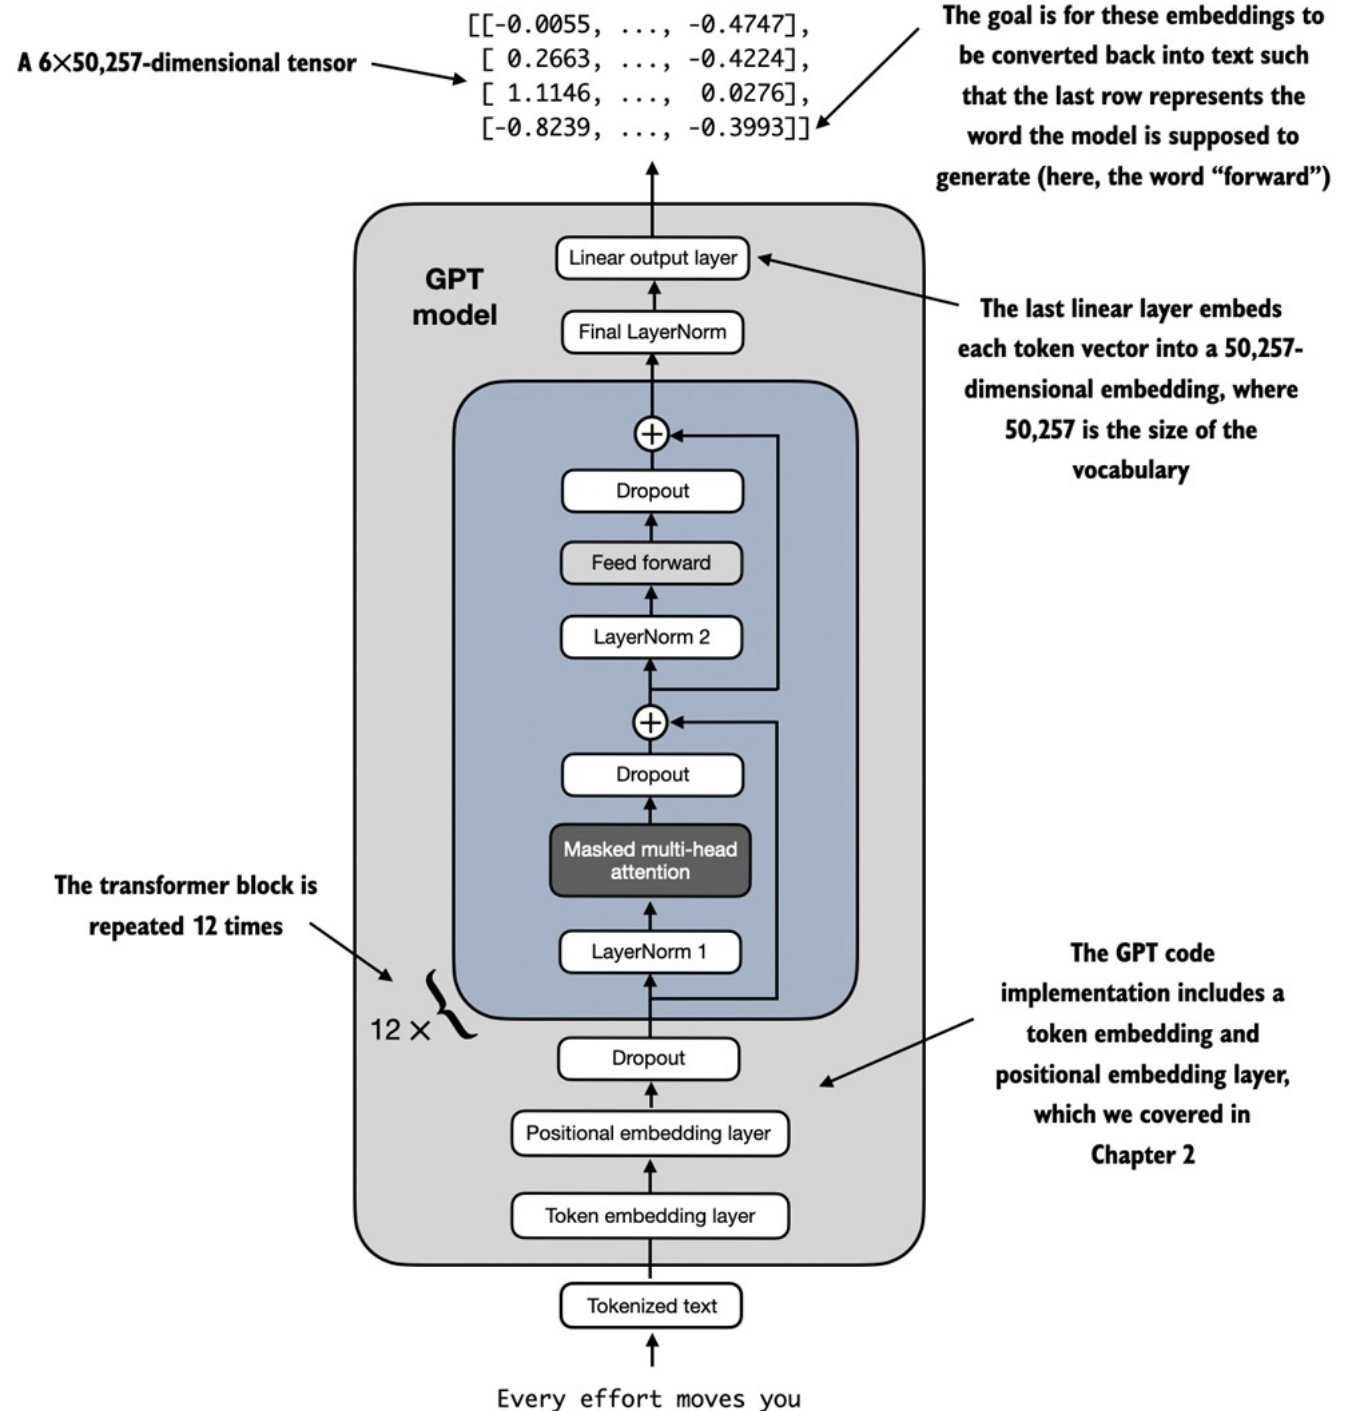

**An overview of the GPT model architecture. This figure illustrates the flow of data
through the GPT model. Starting from the bottom, tokenized text is first converted into token
embeddings, which are then augmented with positional embeddings. This combined information
forms a tensor that is passed through a series of transformer blocks shown in the center (each
containing multi-head attention and feed forward neural network layers with dropout and layer
normalization), which are stacked on top of each other and repeated 12 times.**

*  We are almost there: now let's plug in the transformer block into the architecture we coded at the very beginning of this chapter so that we obtain a usable GPT architecture
*  Note that the transformer block is repeated multiple times; in the case of the smallest 124M GPT-2 model, we repeat it 12 times.


*  The corresponding code implementation, where `cfg["n_layers"] = 12:`

In [31]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

*  Using the configuration of the 124M parameter model, we can now instantiate this GPT model with random initial weights as follows:

In [32]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
         [ 0.3865, -0.8408, -0.6564,  ..., -0.5163,  0.2369, -0.3357],
         [ 0.6989, -0.1829, -0.1631,  ...,  0.1472, -0.6504, -0.0056],
         [-0.4290,  0.1669, -0.1258,  ...,  1.1579,  0.5303, -0.5549]],

        [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
         [ 0.0882, -0.3552, -0.3527,  ...,  1.2930,  0.0053,  0.1898],
         [ 0.6091,  0.4702, -0.4094,  ...,  0.7688,  0.3787, -0.1974],
         [-0.0612, -0.0737,  0.4751,  ...,  1.2463, -0.3834,  0.0609]]],
       grad_fn=<UnsafeViewBackward0>)


As we can see, the output tensor has the shape `[2, 4, 50257]`, since we
passed in 2 input texts with 4 tokens each. The last dimension, 50,257,
corresponds to the vocabulary size of the tokenizer. In the next section, we
will see how to convert each of these 50,257-dimensional output vectors back
into tokens.

-----------------------------------------------------------------------------------------
Before we move on to the next section and code the function that converts the
model outputs into text, let's spend a bit more time with the model
architecture itself and analyze its size.
Using the `numel()` method, short for "number of elements," we can collect
the total number of parameters in the model's parameter tensors:

In [33]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


*  As we see above, this model has 163M, not 124M parameters; why?
*  In the original GPT-2 paper, the researchers applied weight tying, which means that they reused the token embedding layer (`tok_emb`) as the output layer, which means setting `self.out_head.weight = self.tok_emb.weight`
*  The token embedding layer projects the 50,257-dimensional one-hot encoded input tokens to a 768-dimensional embedding representation
*  The output layer projects 768-dimensional embeddings back into a 50,257-dimensional representation so that we can convert these back into words (more about that in the next section)
*  So, the embedding and output layer have the same number of weight parameters, as we can see based on the shape of their weight matrices
*  However, a quick note about its size: we previously referred to it as a 124M parameter model; we can double check this number as follows:

In [34]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


*  In the original GPT-2 paper, the researchers reused the token embedding matrix as an output matrix
*  Correspondingly, if we subtracted the number of parameters of the output layer, we'd get a 124M parameter model:

In [35]:
total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


*  In practice, I found it easier to train the model without weight-tying, which is why we didn't implement it here
*  However, we will revisit and apply this weight-tying idea later when we load the pretrained weights in chapter 5
*  Lastly, we can compute the memory requirements of the model as follows, which can be a helpful reference point:

In [36]:
# Calculate the total size in bytes (assuming float32, 4 bytes per parameter)
total_size_bytes = total_params * 4

# Convert to megabytes
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


##4.7 Generating text

In this final section, we will implement the code that converts
the tensor outputs of the GPT model back into text. Before we get started,
let's briefly review how a generative model like an LLM generates text one
word (or token) at a time,

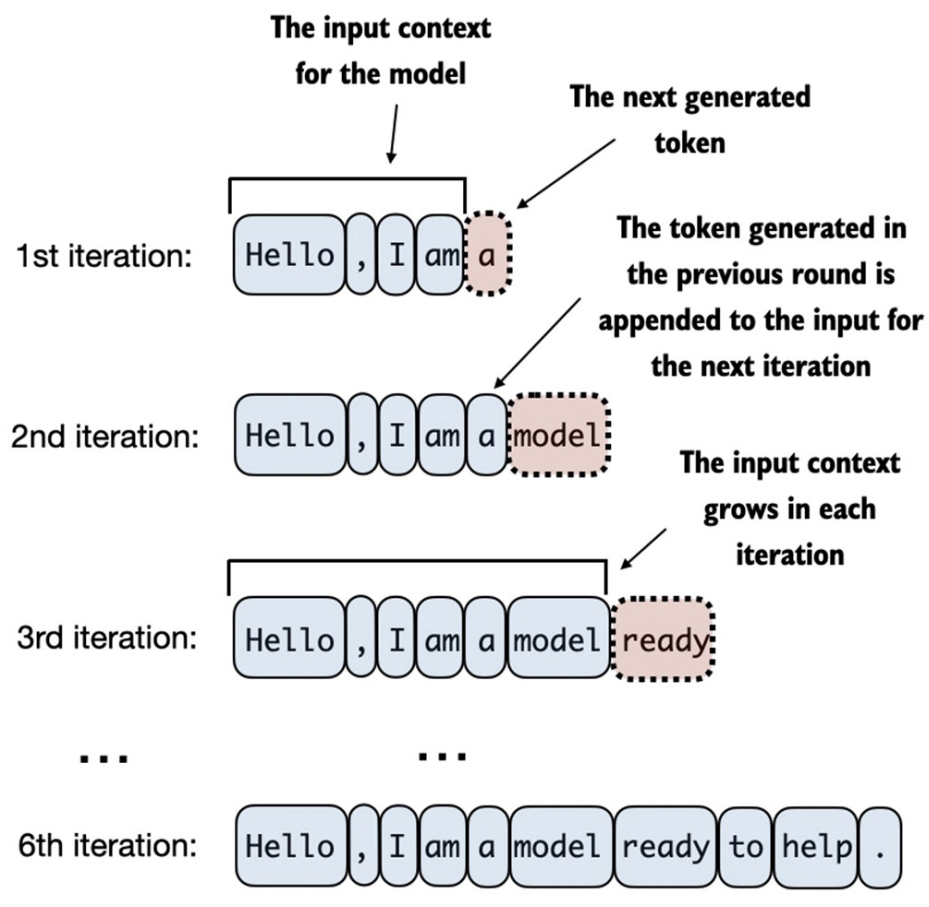

**This diagram illustrates the step-by-step process by which an LLM generates text,
one token at a time. Starting with an initial input context ("Hello, I am"), the model predicts a
subsequent token during each iteration, appending it to the input context for the next round of
prediction. As shown, the first iteration adds "a", the second "model", and the third "ready",
progressively building the sentence.**

**How does a GPT model go from these output tensors to the
generated text shown in the above Figure**

*  The following `generate_text_simple` function implements greedy decoding, which is a simple and fast method to generate text
*  In greedy decoding, at each step, the model chooses the word (or token) with the highest probability as its next output (the highest logit corresponds to the highest probability, so we technically wouldn't even have to compute the softmax function explicitly)
*  In the next notebook, we will implement a more advanced `generate_text` function

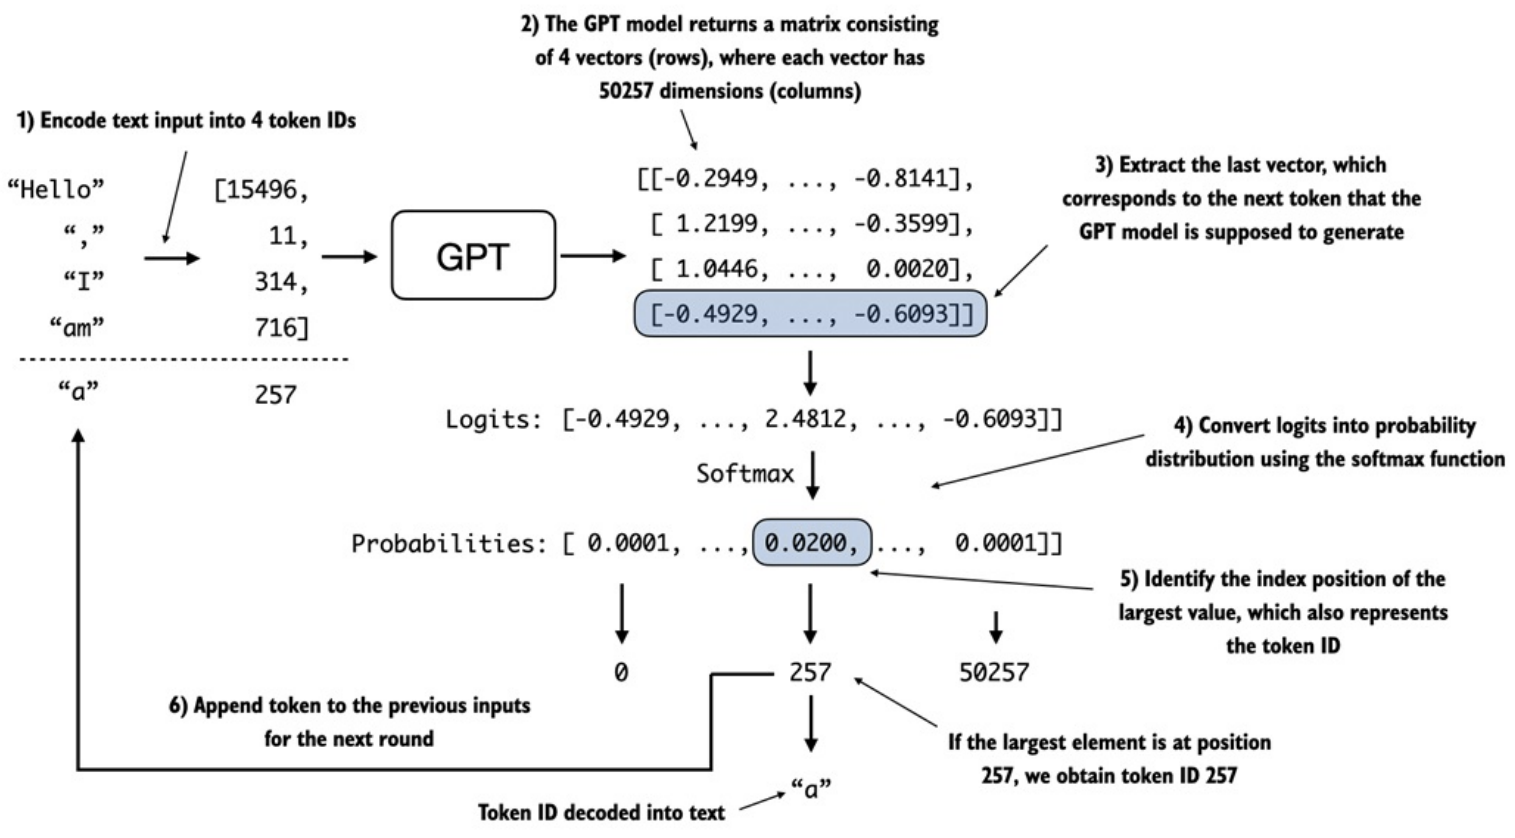

*In each step, the model outputs a matrix with vectors representing potential
next tokens. The vector corresponding to the next token is extracted and
converted into a probability distribution via the softmax function. Within the
vector containing the resulting probability scores, the index of the highest
value is located, which translates to the token ID. This token ID is then
decoded back into text, producing the next token in the sequence. Finally, this
token is appended to the previous inputs, forming a new input sequence for
the subsequent iteration. This step-by-step process enables the model to
generate text sequentially, building coherent phrases and sentences from the
initial input context.*

In [38]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

*  The `generate_text_simple` above implements an iterative process, where it creates one token at a time

The code snippet provided demonstrates a simple implementation of a
generative loop for a language model using PyTorch. It iterates for a
specified number of new tokens to be generated, crops the current context to
fit the model's maximum context size, computes predictions and then selects
the next token based on the highest probability prediction.

In the preceeding code, the generate_text_simple function, we use a
softmax function to convert the logits into a probability distribution from
which we identify the position with the highest value via torch.argmax. The
softmax function is monotonic, meaning it preserves the order of its inputs
when transformed into outputs. So, in practice, the softmax step is redundant
since the position with the highest score in the softmax output tensor is the
same position in the logit tensor. In other words, we could apply the
`torch.argmax` function to the logits tensor directly and get identical results.
However, we coded the conversion to illustrate the full process of
transforming logits to probabilities, which can add additional intuition, such
as that the model generates the most likely next token, which is known as
*greedy decoding*.

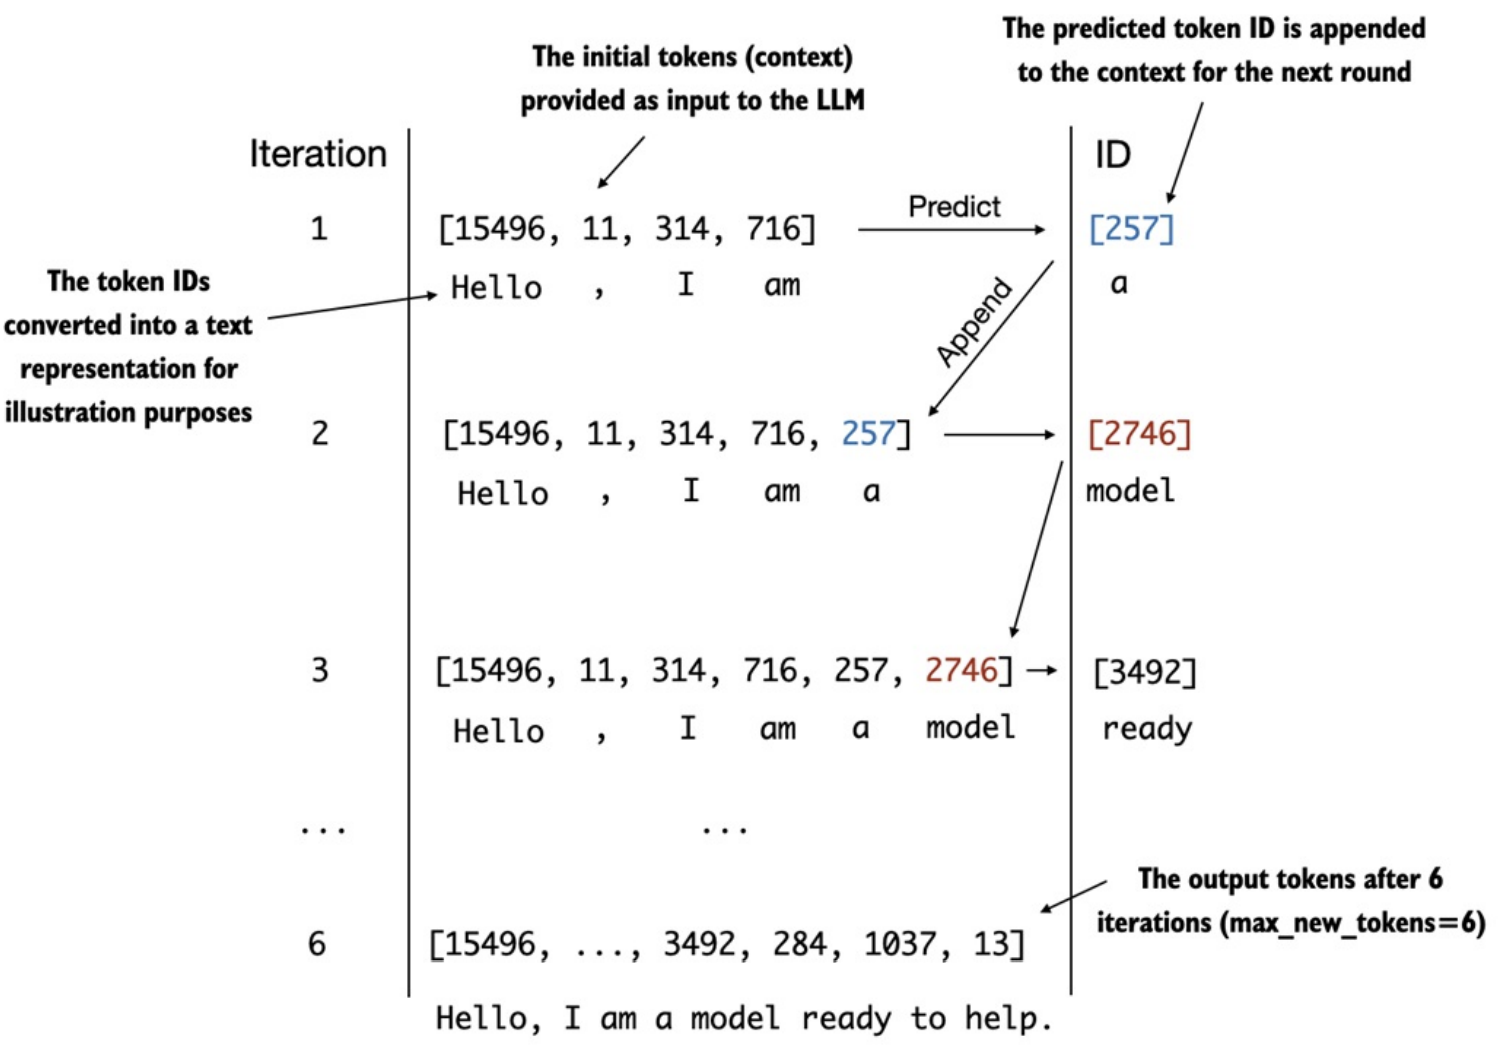

*  Let's prepare an input example:

In [40]:
start_context = "Hello, I am"
print("The encoded IDs are as follows:")
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

The encoded IDs are as follows:
encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


Next, we put the model into `.eval()` mode, which disables random
components like dropout, which are only used during training, and use the
`generate_text_simple` function on the encoded input tensor:

In [42]:
model.eval() # disable dropout
print("The resulting output token IDs are as follows:")

out = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output:", out)
print("Output length:", len(out[0]))

The resulting output token IDs are as follows:
Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


*  Using the `.decode` method of the tokenizer, we can convert the IDs back into
text:

In [43]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


*  Note that the model is untrained; hence the random output texts above
*  We will train the model in the next notebook